In [1]:
import pandas as pd
import glob
import numpy as np
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pwd

'C:\\Users\\nimod\\OneDrive - Université de Technologie de Troyes\\Fil_rouge'

In [3]:
glob.glob('./Tables_traitees/*')

['./Tables_traitees\\Communes_manquantes.csv',
 './Tables_traitees\\Infos_communes.csv',
 './Tables_traitees\\Infos_communes_avec_prix_estimé.csv',
 './Tables_traitees\\Population-Superficie_communes.csv',
 './Tables_traitees\\PrixMoy_m2_avec_code_commune.csv',
 './Tables_traitees\\Stations_carburant_avec_code_commune.csv',
 './Tables_traitees\\Stations_electriques_avec_code_commune.csv']

| N° | Dataframe | Description |
| -- | -- | -- |  
| 1. | df_elec | Bornes électriques |
| 2. | df_carb | Stations Carburant | 
| 3. | df_pop | Population et superficie commune | 
| 4. | df_com | Infos communes | 
| 5. | df_commune_immo | Prix au m2 | 
| 6. | df_commune_adj | Communes adjacentes | |

# Analyse des tables traitées

## df_elec - Bornes électriques

In [4]:
df_elec = pd.read_csv('./Tables_traitees\\Stations_electriques_avec_code_commune.csv', sep=';')

C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\2994795067.py:1: DtypeWarning: Columns (12,52,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_elec = pd.read_csv('./Tables_traitees\\Stations_electriques_avec_code_commune.csv', sep=';')


In [5]:
rename = {col:"1_"+col for col in df_elec.columns}
df_elec.rename(columns = rename, inplace=True)

In [6]:
df_elec.shape

(63715, 64)

In [7]:
df_elec.columns

Index(['1_Nom aménageur', '1_SIREN aménageur', '1_Contact aménageur',
       '1_Nom opérateur', '1_Contact opérateur', '1_Téléphone opérateur',
       '1_Nom enseigne', '1_ID station itinérance', '1_ID station local',
       '1_Nom station', '1_Implantation station', '1_Adresse station',
       '1_Code INSEE commune', '1_Coordonnées', '1_Nombre Points de charge',
       '1_ID PDC itinérance', '1_ID PDC local', '1_Puissance nominale',
       '1_Prise type E/F', '1_Prise type 2', '1_Prise type combo ccs',
       '1_Prise type chademo', '1_Prise type autre', '1_Gratuit',
       '1_Paiement acte', '1_Paiement CB', '1_Paiement autre',
       '1_Tarification', '1_Condition accès', '1_Réservation', '1_Horaires',
       '1_Accessibilité PMR', '1_Restriction gabarit', '1_Station deux roues',
       '1_Raccordement', '1_Num PDL', '1_Date mise en service',
       '1_Observations', '1_Date de Mise à Jour', '1_cable_t2_attache',
       '1_Dernière modification', '1_datagouv dataset id',
       '1_d

In [8]:
df_elec[df_elec['1_code_commune_n'].isna()].shape

(55, 64)

In [9]:
# df_elec[df_elec['1_code_commune_n'].isna()].to_csv('./Tables_traitees\\Communes_manquantes.csv', sep=';',index=False)

## df_carb - Stations Carburant

In [10]:
df_carb = pd.read_csv('./Tables_traitees\\Stations_carburant_avec_code_commune.csv', sep=';')

In [11]:
rename = {col:"2_"+col for col in df_carb.columns}
df_carb.rename(columns = rename, inplace=True)

In [12]:
df_carb.shape

(12450, 25)

In [13]:
df_carb.columns

Index(['2_Identifiant', '2_Code Postal', '2_Présence', '2_Adresse', '2_Ville',
       '2_Automate 24-24', '2_Timetable', '2_Carburant', '2_Rupture',
       '2_Mise à jour', '2_Prix Gazole', '2_Prix SP95', '2_Prix SP98',
       '2_Prix GPLc', '2_Prix E10', '2_Prix E85', '2_Services', '2_Marque',
       '2_Nom', '2_Geo Point', '2_Code INSEE', '2_Commune', '2_code_commune_n',
       '2_lat', '2_lon'],
      dtype='object')

In [14]:
df_carb.dtypes

2_Identifiant         int64
2_Code Postal         int64
2_Présence           object
2_Adresse            object
2_Ville              object
2_Automate 24-24     object
2_Timetable          object
2_Carburant          object
2_Rupture            object
2_Mise à jour        object
2_Prix Gazole       float64
2_Prix SP95         float64
2_Prix SP98         float64
2_Prix GPLc         float64
2_Prix E10          float64
2_Prix E85          float64
2_Services           object
2_Marque             object
2_Nom                object
2_Geo Point          object
2_Code INSEE         object
2_Commune            object
2_code_commune_n     object
2_lat               float64
2_lon               float64
dtype: object

In [15]:
df_carb[:3]

,2_Identifiant,2_Code Postal,2_Présence,2_Adresse,2_Ville,2_Automate 24-24,2_Timetable,2_Carburant,2_Rupture,2_Mise à jour,...,2_Prix E85,2_Services,2_Marque,2_Nom,2_Geo Point,2_Code INSEE,2_Commune,2_code_commune_n,2_lat,2_lon
0,14730002,14730,A,Autoroute de Normandie,GIBERVILLE,NaN,NaN,Gazole,"SP95,E85,GPLc",2020-01-06T12:44:00+01:00,...,NaN,NaN,Esso,ESSO GIBERVILLE,"49.16711, -0.28803",14301,GIBERVILLE,14301,49.167110,-0.288030
1,84550001,84550,A,A7 AIRE DE MORNAS VILLAGE,MORNAS,NaN,NaN,"Gazole,SP95,E85,GPLc,E10,SP98",NaN,2020-01-12T09:51:06+01:00,...,0.749000,"Restauration à emporter,Carburant additivé,Toi...",Carrefour,AIRE DE MORNAS VILLAGE (LES CROUSILLES),"44.2036953693, 4.72398720666",84083,MORNAS,84083,44.203695,4.723987
2,67202004,67202,R,"RN 4 Route de Saverne, Station Total Access",WOLFISHEIM,Oui,"{""Dimanche"": {""fermeture"": ""20.00"", ""ouvert"": ...","E85,E10,SP98","GPLc,SP95",2022-11-22T08:52:37+01:00,...,0.000929,"Relais colis,Boutique alimentaire,Boutique non...",NaN,NaN,NaN,67551,WOLFISHEIM,67551,NaN,NaN


In [16]:
len(df_carb['2_Identifiant'].unique())

10962

In [17]:
df_carb[df_carb['2_code_commune_n']=='11220']

,2_Identifiant,2_Code Postal,2_Présence,2_Adresse,2_Ville,2_Automate 24-24,2_Timetable,2_Carburant,2_Rupture,2_Mise à jour,...,2_Prix E85,2_Services,2_Marque,2_Nom,2_Geo Point,2_Code INSEE,2_Commune,2_code_commune_n,2_lat,2_lon
79,13014014,13014,R,26 CHEMIN DE SAINTE MARTHE,MARSEILLE,Oui,"{""Mardi"": {""ouverture"": ""00.00"", ""fermeture"": ...","Gazole,E10,SP98",NaN,2020-11-17T06:00:00+01:00,...,NaN,"Carburant additivé,Toilettes publiques,Boutiqu...",NaN,NaN,NaN,NaN,NaN,11220,NaN,NaN
206,13012023,13012,R,56 rue Saint Jean du desert,MARSEILLE,NaN,NaN,"SP95,SP98","E85,GPLc,E10",2018-05-18T09:32:57+02:00,...,NaN,"Carburant additivé,Toilettes publiques,Boutiqu...",NaN,NaN,NaN,NaN,NaN,11220,NaN,NaN
221,13014008,13014,R,26 Chemin de Sainte-Marthe,MARSEILLE,NaN,NaN,"Gazole,E10,SP98","SP95,E85,GPLc",2019-12-01T06:00:00+01:00,...,NaN,"Carburant additivé,Toilettes publiques,Boutiqu...",Agip,AGIP MARSEILLE SAINTE MARTHE,"43.3177505955, 5.37430169143",NaN,NaN,11220,43.317751,5.374302
275,13010012,13010,R,260 BOULEVARD PAUL CLAUDEL,MARSEILLE,Oui,"{""Dimanche"": {""ouvert"": 0}, ""Jeudi"": {""fermetu...","Gazole,SP98","E85,GPLc,E10,SP95",2022-09-29T15:20:30+02:00,...,NaN,"Boutique non alimentaire,Restauration à emport...",NaN,NaN,NaN,NaN,NaN,11220,NaN,NaN
415,13012015,13012,R,7 Chemin des Amaryllis,MARSEILLE,Non,"{""Dimanche"": {""ouvert"": 1}, ""Jeudi"": {""ouvert""...",Gazole,NaN,2021-08-05T08:00:00+02:00,...,NaN,"DAB (Distributeur automatique de billets),Lava...",Carrefour Market,SUPERMARCHÉ CARREFOUR MARKET,"43.31733, 5.43951",NaN,NaN,11220,43.317330,5.439510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11137,13012022,13012,R,67 AVENUE DES CAILLOLS,MARSEILLE,NaN,NaN,"Gazole,E85,E10,SP98",GPLc,2023-10-14T00:01:00+02:00,...,0.000994,"Boutique alimentaire,Restauration à emporter,S...",NaN,NaN,NaN,NaN,NaN,11220,NaN,NaN
11594,13003004,13003,R,83 BD DE PLOMBIERES,MARSEILLE,Non,"{""Dimanche"": {""fermeture"": ""20.00"", ""ouvert"": ...","Gazole,E85,E10,SP98",GPLc,2023-10-14T00:01:00+02:00,...,0.000994,"Boutique alimentaire,Boutique non alimentaire,...",NaN,NaN,NaN,NaN,NaN,11220,NaN,NaN
11595,13008014,13008,R,1 Avenue d'Odessa,MARSEILLE,Oui,"{""Dimanche"": {""ouvert"": 1}, ""Jeudi"": {""ouvert""...","Gazole,SP95,SP98","E85,GPLc,E10,E85,GPLc,E10",2023-10-11T07:08:32+02:00,...,NaN,"Boutique alimentaire,Boutique non alimentaire,...",NaN,NaN,NaN,NaN,NaN,11220,NaN,NaN
11596,13013016,13013,R,AVENUE FREDERIC MISTRAL,MARSEILLE,Oui,"{""Dimanche"": {""ouvert"": 1}, ""Jeudi"": {""ouvert""...","Gazole,E85,GPLc,E10,SP98",SP95,2023-10-14T00:01:00+02:00,...,0.000994,"Boutique alimentaire,Restauration à emporter,S...",NaN,NaN,NaN,NaN,NaN,11220,NaN,NaN


## df_pop - Population & superficie communes

In [18]:
df_pop = pd.read_csv('./Tables_traitees\\Population-Superficie_communes.csv', sep=';',dtype={'Code département':str,'Code INSEE (commune ou arrondissement)':str })

In [19]:
rename = {col:"3_"+col for col in df_pop.columns}
df_pop.rename(columns = rename, inplace=True)

In [20]:
df_pop.shape

(36750, 16)

In [21]:
df_pop.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2'],
      dtype='object')

In [22]:
df_pop[:3]

,3_Code région,3_Nom de la région,3_Code département,3_Code commune,3_Nom de la commune,3_Population municipale,3_Population comptée à part,3_Population totale,3_Année recensement,3_Année utilisation,3_Code INSEE (commune ou arrondissement),3_Superficie de la commune,3_Statut,3_Code EPCI,3_EPCI,3_Densité_hab_par_km2
0,84.0,Auvergne-Rhône-Alpes,01,1.0,L' Abergement-Clémenciat,767.0,18.0,785.0,2016,2019,01001,15.65,Commune,200035210,CC Chalaronne Centre,49.009585
1,84.0,Auvergne-Rhône-Alpes,01,2.0,L' Abergement-de-Varey,243.0,1.0,244.0,2016,2019,01002,9.13,Commune,240100883,CC de la Plaine de l'Ain,26.615553
2,84.0,Auvergne-Rhône-Alpes,01,4.0,Ambérieu-en-Bugey,14081.0,437.0,14518.0,2016,2019,01004,24.49,Commune,240100883,CC de la Plaine de l'Ain,574.969375


## df_com - Infos Communes

In [23]:
df_com = pd.read_csv('./Tables_traitees\\Infos_communes.csv', sep=';')

In [24]:
rename = {col:"4_"+col for col in df_com.columns}
df_com.rename(columns = rename, inplace=True)

In [25]:
df_com.shape

(36742, 20)

In [26]:
df_com.dtypes

4_Code INSEE              object
4_Code Postal             object
4_Commune                 object
4_Département             object
4_Région                  object
4_Statut                  object
4_Altitude Moyenne       float64
4_Superficie             float64
4_Population             float64
4_geo_point_2d            object
4_geo_shape               object
4_ID Geofla                int64
4_Code Commune             int64
4_Code Canton              int64
4_Code Arrondissement      int64
4_Code Département        object
4_Code Région              int64
4_lat                    float64
4_lon                    float64
4_Densité_hab_par_km2    float64
dtype: object

## df_commune_immo - Prix au m2

In [27]:
df_commune_immo = pd.read_csv('./Tables_traitees\\PrixMoy_m2_avec_code_commune.csv', sep=';')

In [28]:
rename = {col:"5_"+col for col in df_commune_immo.columns}
df_commune_immo.rename(columns = rename, inplace=True)

In [29]:
df_commune_immo.shape

(34886, 11)

In [30]:
df_commune_immo.columns

Index(['5_ID', '5_INSEE_COM', '5_INSEE_DEP', '5_INSEE_REG', '5_CODE_EPCI',
       '5_NOM_COM_M', '5_POPULATION', '5_Nb_Ventes', '5_PrixMoyen_M2',
       '5_nb_digits_code_INSEE', '5_code_commune_n'],
      dtype='object')

In [31]:
df_commune_immo.dtypes

5_ID                       object
5_INSEE_COM                object
5_INSEE_DEP                object
5_INSEE_REG                 int64
5_CODE_EPCI               float64
5_NOM_COM_M                object
5_POPULATION                int64
5_Nb_Ventes               float64
5_PrixMoyen_M2            float64
5_nb_digits_code_INSEE      int64
5_code_commune_n           object
dtype: object

In [32]:
df_commune_immo[:3]

,5_ID,5_INSEE_COM,5_INSEE_DEP,5_INSEE_REG,5_CODE_EPCI,5_NOM_COM_M,5_POPULATION,5_Nb_Ventes,5_PrixMoyen_M2,5_nb_digits_code_INSEE,5_code_commune_n
0,COMMUNE_0000000009760754,32216,32,76,200072320.0,LOURTIES MONBRUN,152,NaN,NaN,5,32216
1,COMMUNE_0000000009756744,47033,47,75,200036523.0,BOUDY DE BEAUREGARD,412,4.0,1421.0,5,47033
2,COMMUNE_0000000009760252,32009,32,76,243200425.0,ARMOUS ET CAU,86,NaN,NaN,5,32009


In [33]:
len(df_commune_immo['5_code_commune_n'].unique())

34886

## df_commune_adj - Communes adjacentes

In [34]:
df_commune_adj = pd.read_csv('.\\Tables_brutes\\Communes_adjacentes\\communes_adjacentes_2022.csv',sep=',',dtype= {'insee':str})

In [35]:
rename = {col:"6_"+col for col in df_commune_adj.columns}
df_commune_adj.rename(columns = rename, inplace=True)

In [36]:
df_commune_adj.dtypes

6_insee            object
6_nom              object
6_nb_voisins        int64
6_insee_voisins    object
6_noms_voisins     object
6_cap_voisins      object
6_type             object
dtype: object

In [37]:
df_commune_adj.shape

(34990, 7)

In [38]:
df_commune_adj[:3]

,6_insee,6_nom,6_nb_voisins,6_insee_voisins,6_noms_voisins,6_cap_voisins,6_type
0,01001,L'Abergement-Clémenciat,6,01412|01093|01028|01146|01351|01188,Sulignat|Châtillon-sur-Chalaronne|Baneins|Domp...,48|144|203|234|260|322,NaN
1,01002,L'Abergement-de-Varey,6,01056|01277|01384|01007|01363|01199,Boyeux-Saint-Jérôme|Nivollet-Montgriffon|Saint...,43|115|172|265|302|344,NaN
2,01004,Ambérieu-en-Bugey,7,01384|01421|01041|01345|01089|01007|01149,Saint-Rambert-en-Bugey|Torcieu|Bettant|Saint-D...,102|151|190|250|284|347|360,NaN


In [39]:
df_commune_adj[df_commune_adj['6_insee']=="01059"]

,6_insee,6_nom,6_nb_voisins,6_insee_voisins,6_noms_voisins,6_cap_voisins,6_type


# Merge des dataframe

In [40]:
df = pd.DataFrame()
df = pd.merge(df_pop,df_commune_immo, left_on="3_Code INSEE (commune ou arrondissement)",
              right_on="5_code_commune_n",how="left")

In [41]:
df = pd.merge(df,df_commune_adj, left_on="3_Code INSEE (commune ou arrondissement)",
              right_on="6_insee",how="left")

In [42]:
df = pd.merge(df, df_com, left_on="3_Code INSEE (commune ou arrondissement)",
              right_on="4_Code INSEE",how="left")

In [43]:
# # ATTENTION
# df['Prix_estimé'] = df.apply(lambda x: estim_prix(x['Code INSEE (commune ou arrondissement)']),axis=1)
# df = pd.read_csv('./Tables_traitees\\Infos_communes_avec_prix_estimé.csv',sep=';',dtype={'Code département':str,'Code INSEE (commune ou arrondissement)':str,
                    # "INSEE_DEP":str,"ID":str,"INSEE_COM":str,"code_commune_n":str,"insee":str,"Code INSEE":str,"Code Département":str })

In [44]:
df.shape

(36750, 54)

In [45]:
# Valeurs uniques et manquant par colonne
df_analyse = []
manquantes = df.isna().sum()
for t in df.columns:
    row = {}
    row['Variable']=t
    row['type']= df[t].dtypes
    row['Nb_val_unique']=len(df[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

,Variable,type,Nb_val_unique,Nb_manquant
33,6_type,object,9,35990
23,5_Nb_Ventes,float64,554,9928
24,5_PrixMoyen_M2,float64,3709,9928
20,5_CODE_EPCI,float64,1237,1916
18,5_INSEE_DEP,object,97,1867
25,5_nb_digits_code_INSEE,float64,2,1867
19,5_INSEE_REG,float64,14,1867
21,5_NOM_COM_M,object,32430,1867
22,5_POPULATION,float64,5734,1867
26,5_code_commune_n,object,34884,1867


## Estimation des manquants prix moyen m2 

- Choisissons d'abord une liste d'index de 6000 valeurs
- Nous n'utiliserons pas ces lignes pour les entrainements de modèles de ML, uniquement pour mesurer la précision de chaque modèle
- SVP pour entrainer vos modèles, utiliser désormais df_train
- Ensuite vous faites la prédictions sur tout le dataframe df
- Pour la comparaison on utilisera que les lignes correspondantes aux index_to_remove, ainsi on peut comparer les résultats sur des données non entrainées

In [264]:
np.random.seed(97)
index_to_remove = np.random.randint(0,len(df)+1, size=6000)
df_train = df.drop(index_to_remove)

array([10659, 24681, 24243, ..., 12627, 21728, 20206])

On commence par choisir les variables qui vont participer à l'imputation

In [265]:
sel_col = ['3_Code INSEE (commune ou arrondissement)','3_Code département', '5_PrixMoyen_M2', 
           'A_Prix_estimé_mean', 'A_Prix_consolidé_mean', 'B_Prix_estimé_median', 'B_Prix_consolidé_median', 
           '6_insee_voisins']

In [266]:
# correction d'une ligne (la seule, dont la superficie et la densité n'étaient pas remplies
df.loc[31441, '3_Superficie de la commune'] = 8.71
df.loc[31441, '3_Densité_hab_par_km2'] = 254.0/8.71
df.loc[31441,:]

3_Code région                                                                            28.0
3_Nom de la région                                                                  Normandie
3_Code département                                                                         76
3_Code commune                                                                          601.0
3_Nom de la commune                                                              Saint-Lucien
3_Population municipale                                                                 252.0
3_Population comptée à part                                                               2.0
3_Population totale                                                                     254.0
3_Année recensement                                                                      2016
3_Année utilisation                                                                      2019
3_Code INSEE (commune ou arrondissement)                    

In [267]:
df_m2 = df[df['5_PrixMoyen_M2'].isna()==False]
# df_m2[sel_col]

In [268]:
df_m2.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '6_insee', '6_nom', '6_nb_voisins',
       '6_insee_voisins', '6_noms_voisins', '6_cap_voisins', '6_type',
       '4_Code INSEE', '4_Code Postal', '4_Commune', '4_Département',
       '4_Région', '4_Statut', '4_Altitude Moyenne', '4_Superficie',
       '4_Population', '4_geo_point_2d', '4_geo_shape', '4_ID Geofla',
       '4_Code Commune', '4_Code Canton', '4_Code Arrondissement',
   

In [269]:
from sklearn.model_selection import KFold
nb_kfold = 5
rdm_state = 97
kf = KFold(n_splits=nb_kfold,shuffle=True, random_state = rdm_state)

### A-Par moyenne et B-médiane des communes avoisinantes

In [270]:
# On initialise les nouvelles variables
df['A_Prix_consolidé_mean'] = np.nan
df['A_Prix_estimé_mean'] = np.nan
df['B_Prix_consolidé_median'] = np.nan
df['B_Prix_estimé_median'] = np.nan
df['5_PrixMoyen_M2'] = df['5_PrixMoyen_M2'].astype(float)

In [271]:
# On crée un dictionnaire pour aller plus vite dans la recherche des communes voisines 
voisins_dict = df_commune_adj.set_index('6_insee')['6_insee_voisins'].to_dict()
df['A_Prix_consolidé_mean'] = df['5_PrixMoyen_M2']
df['B_Prix_consolidé_median'] = df['5_PrixMoyen_M2']

In [272]:
def estim_prix(code, vois, prix_mean, prix_median):
    try:
        # voisins = df_commune_adj.loc[df_commune_adj['insee']==code,'insee_voisins'].values[0].split('|')
        voisins = vois[str(code)].split('|')
        # print(voisins)
        prix_voisins_mean = list()
        prix_voisins_median = list()
        for v in voisins:
            try:
                # p = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Prix_consolidé'].values[0]
                p1 = prix_mean[str(v)]
                p2 = prix_median[str(v)]
            except:
                p1, p2 = None, None
            # nb = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Nb_Ventes'].values[0]
            prix_voisins_mean.append(float(p1))
            prix_voisins_median.append(float(p2))
        # print(code, voisins,prix_voisins)
        mean = np.nanmean(prix_voisins_mean)
        median = np.nanmedian(prix_voisins_median)
    except:
        mean = np.nan
        median = np.nan
    # print(code, mean, median)
    # print('-------')
    return pd.Series({'A_Prix_estimé_mean': mean, 'B_Prix_estimé_median': median})

In [273]:
%%time
n_iterations = 10
i=0
print('iteration:',i,'nbre de manquants:', sum(pd.isna(df['A_Prix_consolidé_mean'])))
while i<n_iterations:
    Prix_consolidé_dict_mean = df.set_index('3_Code INSEE (commune ou arrondissement)')['A_Prix_consolidé_mean'].to_dict()
    Prix_consolidé_dict_median = df.set_index('3_Code INSEE (commune ou arrondissement)')['B_Prix_consolidé_median'].to_dict()
    df[['A_Prix_estimé_mean', 'B_Prix_estimé_median']] = df.apply(lambda x: estim_prix(x['3_Code INSEE (commune ou arrondissement)'], 
                                                                                      voisins_dict, Prix_consolidé_dict_mean, 
                                                                                       Prix_consolidé_dict_median ),axis=1)
    df['A_Prix_consolidé_mean'] = df['A_Prix_estimé_mean']
    df['B_Prix_consolidé_median'] = df['B_Prix_estimé_median']
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'A_Prix_consolidé_mean'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'B_Prix_consolidé_median'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    nb_manquants = sum(pd.isna(df['A_Prix_consolidé_mean']))
    i+=1
    print('iteration:',i,'nbre de manquants:',nb_manquants)

iteration: 0 nbre de manquants: 9928


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 1 nbre de manquants: 4075


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 2 nbre de manquants: 3495


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 3 nbre de manquants: 3238


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 4 nbre de manquants: 3047


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 5 nbre de manquants: 2868


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 6 nbre de manquants: 2713


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 7 nbre de manquants: 2557


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 8 nbre de manquants: 2424


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 9 nbre de manquants: 2317


C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


iteration: 10 nbre de manquants: 2234
CPU times: total: 1min 33s
Wall time: 2min 21s


In [274]:
estim_prix(df.loc[0,'3_Code INSEE (commune ou arrondissement)'], voisins_dict, Prix_consolidé_dict_mean, Prix_consolidé_dict_median)

A_Prix_estimé_mean      2167.5
B_Prix_estimé_median    2080.5
dtype: float64

In [275]:
estim_prix(df.loc[53,'3_Code INSEE (commune ou arrondissement)'], voisins_dict, Prix_consolidé_dict_mean, Prix_consolidé_dict_median)

A_Prix_estimé_mean     NaN
B_Prix_estimé_median   NaN
dtype: float64

In [276]:
estim_prix(df.loc[36745,'3_Code INSEE (commune ou arrondissement)'], voisins_dict, Prix_consolidé_dict_mean, Prix_consolidé_dict_median)

C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3912908387.py:20: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(prix_voisins_median)


A_Prix_estimé_mean     NaN
B_Prix_estimé_median   NaN
dtype: float64

In [234]:
df.loc[:20, sel_col]

,3_Code INSEE (commune ou arrondissement),3_Code département,5_PrixMoyen_M2,A_Prix_estimé_mean,A_Prix_consolidé_mean,B_Prix_estimé_median,B_Prix_consolidé_median,6_insee_voisins
0,01001,01,1938.0,2167.500000,1938.000000,2080.5,1938.0,01412|01093|01028|01146|01351|01188
1,01002,01,1130.0,1503.879308,1130.000000,1458.5,1130.0,01056|01277|01384|01007|01363|01199
2,01004,01,2005.0,1725.714286,2005.000000,1678.0,2005.0,01384|01421|01041|01345|01089|01007|01149
3,01005,01,2442.0,2647.857143,2442.000000,2701.0,2442.0,01382|01207|01261|01362|01318|01398|01446
4,01006,01,1155.0,1460.333333,1155.000000,1287.0,1155.0,01358|01110|01117|01216|01233|01190
5,01007,01,1963.0,1739.555556,1963.000000,1731.0,1963.0,01363|01002|01384|01149|01004|01089|01314|0143...
6,01008,01,1940.0,1789.200000,1940.000000,1693.0,1940.0,01041|01431|01202|01213|01345
7,01009,01,966.0,1388.400000,966.000000,1286.0,966.0,01098|01034|01015|01358|01116
8,01010,01,1970.0,1812.571429,1970.000000,1723.0,1970.0,01407|74269|73180|73286|01138|01453|01118
9,01011,01,889.0,1569.142857,889.000000,1552.0,889.0,01087|01269|01265|01237|01181|01031|01283


In [235]:
df_prix_na = df[df['A_Prix_consolidé_mean'].isna()]

In [236]:
df_prix_na.shape

(2234, 59)

In [237]:
print(len(df_prix_na.loc[pd.isna(df_prix_na['6_insee_voisins']),sel_col]))
df_prix_na.loc[pd.isna(df_prix_na['6_insee_voisins']),sel_col]

1750


,3_Code INSEE (commune ou arrondissement),3_Code département,5_PrixMoyen_M2,A_Prix_estimé_mean,A_Prix_consolidé_mean,B_Prix_estimé_median,B_Prix_consolidé_median,6_insee_voisins
53,01059,01,NaN,NaN,NaN,NaN,NaN,NaN
83,01091,01,NaN,NaN,NaN,NaN,NaN,NaN
89,01097,01,NaN,NaN,NaN,NaN,NaN,NaN
111,01119,01,NaN,NaN,NaN,NaN,NaN,NaN
113,01122,01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
36183,91222,91,NaN,NaN,NaN,NaN,NaN,NaN
36510,95259,95,NaN,NaN,NaN,NaN,NaN,NaN
36630,97110,971,NaN,NaN,NaN,NaN,NaN,NaN
36648,97130,971,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
print(len(df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),sel_col]))
df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),sel_col]

484


,3_Code INSEE (commune ou arrondissement),3_Code département,5_PrixMoyen_M2,A_Prix_estimé_mean,A_Prix_consolidé_mean,B_Prix_estimé_median,B_Prix_consolidé_median,6_insee_voisins
22033,57006,57,NaN,NaN,NaN,NaN,NaN,57261|57083|57201|57355|57748|57745|57750
22040,57013,57,NaN,NaN,NaN,NaN,NaN,57260|57408|57360|57202|57659
22043,57016,57,NaN,NaN,NaN,NaN,NaN,57516|57110|57700|57106
22072,57046,57,NaN,NaN,NaN,NaN,NaN,57541|67340|67358|67265|67392|57489|57188
22084,57058,57,NaN,NaN,NaN,NaN,NaN,57202|57360|57101|57222|57521|57227
...,...,...,...,...,...,...,...,...
36745,97613,976,NaN,NaN,NaN,NaN,NaN,97602|97617|97601
36746,97614,976,NaN,NaN,NaN,NaN,NaN,97611|97607|97606|97616|97605|97617
36747,97615,976,NaN,NaN,NaN,NaN,NaN,97608
36748,97616,976,NaN,NaN,NaN,NaN,NaN,97614|97606|97605


In [ ]:
df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),'3_Code département'].unique()

2 cas pour ceux qui n'ont pas de prix consolidé
- soit ils n'ont pas de voisins identifiés
- soit ils ont des voisins mais n'ont pas de prix, en DOM TOM, départements 97X

In [ ]:
# Ceux qui n'ont pas de prix estimé parce les voisins n'en n'ont pas
df_na = df[df['A_Prix_estimé_mean'].isna() & df['6_insee_voisins'].notna()]
len(df_na)
df_na[:3]

In [ ]:
print(len(df[df['5_PrixMoyen_M2'].isna()]))
print(len(df[df['A_Prix_consolidé_mean'].isna()]))
print(len(df[df['B_Prix_consolidé_median'].isna()]))

In [ ]:
df[df['A_Prix_estimé_mean'].isna() & df['A_Prix_consolidé_mean'].notna()].head()

In [ ]:
for i,x in df.iterrows():
    if pd.notna(x['5_PrixMoyen_M2']) & pd.notna(x['A_Prix_estimé_mean']):
        df.loc[i,'A_delta_prix_mean']=x['5_PrixMoyen_M2']-x['A_Prix_estimé_mean']
        df.loc[i,'B_delta_prix_median']=x['5_PrixMoyen_M2']-x['B_Prix_estimé_median']
    else:
        df.loc[i,'A_delta_prix_mean']= np.nan
        df.loc[i,'B_delta_prix_median']= np.nan

In [ ]:
# df.to_csv(r'C:\Users\nimod\OneDrive - Université de Technologie de Troyes\Fil_rouge\Tables_traitees\Infos_communes_avec_prix_estimé.csv',sep=';',index=False)

In [ ]:
sns.histplot(data=df, x='A_delta_prix_mean', bins=50, kde=False, color='blue')
sns.histplot(data=df, x='B_delta_prix_median', bins=50, kde=False, color='orange')

In [ ]:
df[['A_delta_prix_mean','B_delta_prix_median']].describe()

In [ ]:
sns.boxplot(data=df[['A_delta_prix_mean','B_delta_prix_median']])

In [ ]:
df.columns

In [ ]:
df_m2.shape

In [ ]:
df_m2['A_Prix_estimé_mean'] = df['A_Prix_estimé_mean'][df['5_PrixMoyen_M2'].isna() == False]
df_m2['B_Prix_estimé_median'] = df['B_Prix_estimé_median'][df['5_PrixMoyen_M2'].isna() == False]

In [ ]:
df_m2.shape

### C-Par moyenne et C1-mediane de toute la variable PAUL

In [ ]:
df_m2['C_Prix_estime_mean'] = np.round(np.mean(df_m2['5_PrixMoyen_M2']))
df_m2.shape

### D-Par KNN OUMAR

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Sélection des caractéristiques
features = ['3_Population municipale','5_PrixMoyen_M2', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']

# Création d'un DataFrame avec seulement les caractéristiques sélectionnées
data_subset = df[features]

# Remplacer les valeurs manquantes dans "5_PrixMoyen_M2" par NaN
data_subset['5_PrixMoyen_M2'] = data_subset['5_PrixMoyen_M2'].replace(0, np.nan)  # Assurez-vous de choisir la valeur qui représente une valeur manquante
data_subset['5_PrixMoyen_M2'] = pd.to_numeric(data_subset['5_PrixMoyen_M2'], errors='coerce')

# Imputer les valeurs manquantes avec KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data_subset)

# Normalisation des données
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_imputed)

# Créer un DataFrame avec les données normalisées et le nom des colonnes
columns = data_subset.columns
data_normalized_df = pd.DataFrame(data_normalized, columns=columns)

# Ajouter une colonne pour stocker les valeurs prédites par le KNN
data_normalized_df['0_KNN_predicted'] = imputer.transform(data_subset)[:, 1]

# Afficher toutes les données
print(data_normalized_df)


In [ ]:
df['5_PrixMoyen_M2']

In [ ]:
data_normalized_df['0_KNN_predicted']

In [ ]:
# Vérifier les valeurs manquantes dans la colonne d'origine
#missing_values_before = df['5_PrixMoyen_M2'].isnull().sum()
#print(f"Nombre de valeurs manquantes dans '5_PrixMoyen_M2' avant l'imputation : {missing_values_before}")

# Imputer les valeurs manquantes avec KNNImputer dans le DataFrame d'origine
#df['5_PrixMoyen_M2'] = imputer.transform(df[features])[:, 1]

# Vérifier à nouveau les valeurs manquantes après l'imputation
#missing_values_after = df['5_PrixMoyen_M2'].isnull().sum()
#print(f"Nombre de valeurs manquantes dans '5_PrixMoyen_M2' après l'imputation : {missing_values_after}")

In [ ]:
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un graphique de dispersion
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', linewidth=2)
plt.title('Valeurs Réelles vs Valeurs Prédites')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist([actual_values, predicted_values], bins=30, label=['Réel', 'Prédit'], alpha=0.7)
plt.legend()
plt.title('Histogramme des Valeurs Réelles et Prédites')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un DataFrame pour Seaborn
data_for_seaborn = pd.DataFrame({'Réel': actual_values, 'Prédit': predicted_values})

# Créer un histogramme avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=data_for_seaborn, bins=30, kde=True)
plt.title('Histogramme des Valeurs Réelles et Prédites avec Seaborn')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
Delta= y_test - Y_pred

In [ ]:
df.columns

### E-Par KNeighborsRegressor OUMAR

In [ ]:
from sklearn.neighbors import KNeighborsRegressor 

data1=df[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon','5_PrixMoyen_M2']]
data1=data1.dropna()
data2=data1.sample(n=data1.shape[0],random_state=1)


data_train= data2[:16819]
data_test= data2[16820:data1.shape[0]]

X_train = data_train[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
y_train=data_train[['5_PrixMoyen_M2']]
X_test = data_test[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
y_test =data_test[['5_PrixMoyen_M2']]
neigh = KNeighborsRegressor(n_neighbors=50)

neigh.fit(X_train, y_train)


In [ ]:
neigh.score(X_test,y_test)

In [ ]:
Y_pred=neigh.predict(X_test)
Delta= y_test - Y_pred


In [ ]:
Delta.describe()

### F-Par RandomForestRegressor PAUL

In [ ]:
pd.set_option('display.max_columns', None)
df_m2.head()
# pd.reset_option('max_columns')

In [ ]:
df_verif_na = df_m2.drop(['6_type', 'A_Prix_estimé_mean', 'B_Prix_estimé_median', 'C_Prix_estime_mean', '5_CODE_EPCI', 
                         '6_insee', '6_nom', '6_nb_voisins', '6_insee_voisins', '6_noms_voisins', '6_cap_voisins'], axis=1)

In [ ]:
df_verif_na[df_verif_na.isna().any(axis=1)]

In [ ]:
df_m2.columns

In [ ]:
X_rf.loc[:,'3_Code département'].astype(object)

In [ ]:
26822*0.9


In [ ]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
        
# X=df_m2[['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
#              '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut', 
#              '4_Superficie','4_Altitude Moyenne','4_lat','4_lon','5_PrixMoyen_M2']]
X_rf = df_m2[['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
             '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut']]
y_rf = df_m2[['5_PrixMoyen_M2']]

X_rf_train = X_rf.loc[:24000,:]
y_rf_train = y_rf.loc[:24000]
X_rf_test = X_rf.loc[24001:,:]
y_rf_test = y_rf.loc[24001:]

# X_rf_train = X_rf.loc[:10000,:]
# y_rf_train = y_rf.loc[:10000]
# X_rf_test = X_rf.loc[24001:,:]
# y_rf_test = y_rf.loc[24001:]

cat = ['3_Code région', '3_Code département', '3_Statut']
for c in cat:
     X_rf.loc[:,c] = X_rf.loc[:,c].astype(object)

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
print(cat_selector(X_rf))
print(num_selector(X_rf))

In [ ]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

In [ ]:
rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=0, n_jobs = -1))
rf_pipeline

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
param_grid = {
    # 'randomforestregressor__n_estimators': [100, 200, 300, 400],
    'randomforestregressor__max_depth': [15, 30, 35],
    'randomforestregressor__max_features': [2, 3, 4],
    # 'randomforestregressor__min_samples_leaf': [2, 3, 4, 5],
    'randomforestregressor__min_samples_split': [10, 12, 14]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    scoring='r2',  # Choisissez la métrique appropriée
    cv=kf
)

grid_search.fit(X_rf_train, y_rf_train.values.ravel())

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)

# Évaluer la performance du modèle sur les données de test
test_score = cross_val_score(grid_search.best_estimator_, X_rf_test, y_rf_test.values.ravel(), cv=kf, scoring='r2')
print("Performance sur les données de test:", test_score.mean())

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_rf_test)
print(grid_search.best_estimator_.score(X_rf_test, y_rf_test.values.ravel()))
sns.histplot(data=y_pred-y_rf_test.values.ravel())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

depth = grid_search.cv_results_['param_randomforestregressor__max_depth'].data
features = grid_search.cv_results_['param_randomforestregressor__max_features'].data
split = grid_search.cv_results_['param_randomforestregressor__min_samples_split'].data
results = grid_search.cv_results_['mean_test_score']
sns.pointplot(x=depth, y=results)

In [ ]:
sns.pointplot(x=features, y=results)

In [ ]:
sns.pointplot(x=split, y=results)

In [ ]:
grid_search.cv_results_['mean_test_score']

In [ ]:
rf_pipeline_test = make_pipeline(tree_preprocessor, RandomForestRegressor(max_depth=15, random_state=0, n_jobs = -1))
rf_pipeline_test.fit(X_rf_train, y_rf_train.values.ravel())
rf_pipeline_test.score(X_rf_test, y_rf_test.values.ravel())

y_pred = rf_pipeline_test.predict(X_rf_test)

sns.histplot(data=y_pred-y_rf_test.values.ravel())

In [ ]:
        
l_profondeur = np.arange(5, 30, 5)
rf_score = []

for train, test in kf.split(X_rf):
    # X_train = X[train,:]
    # y_train = y[train]
    # X_test = X[test,:]
    # y_test = y[test]
    X_train = X_rf.iloc[train,:]
    y_train = y_rf.iloc[train]
    X_test = X_rf.iloc[test,:]
    y_test = y_rf.iloc[test]
    
    for prof in l_profondeur:
        rf = make_pipeline(RandomForestRegressor(max_depth=prof, random_state=0, n_jobs = 10))
        rf.fit(X_train, y_train)
        rf_score.append(rf.score(X_test, y_test))

res_rf_score = np.reshape(rf_score, [nb_kfold, l_profondeur.shape[0]])
res_rf_score = np.mean(res_rf_score, axis = 0)
indice_max = np.unravel_index(np.argmax(res_rf_score), res_rf_score.shape)
print('Indices Best score :', indice_max)
print('Best score :', np.max(res_rf_score))
print('Profondeur best score :', l_profondeur[indice_max])
# data2=data1.sample(n=data1.shape[0],random_state=1)


# data_train= data2[:16819]
# data_test= data2[16820:data1.shape[0]]

# X_train = data_train[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_train=data_train[['5_PrixMoyen_M2']]
# X_test = data_test[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_test =data_test[['5_PrixMoyen_M2']]
# rf = RandomForestRegressor(max_depth=20, random_state=0)

# rf.fit(X_train, y_train)


In [ ]:
rf.score(X_test,y_test)

In [ ]:
Y_pred_rf=rf.predict(X_test)
Delta_rf= y_test['5_PrixMoyen_M2'] - Y_pred_rf
Delta_rf.describe()

In [ ]:
Y_pred_rf.shape

In [ ]:
Y_pred[0:]

In [ ]:
y_test['5_PrixMoyen_M2']

In [ ]:
y_test.shape

In [ ]:
Y_pred=rf.predict(X_test)

In [ ]:

y_test

### G-Par Bayesian Ridge NICOLAS

In [277]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

In [300]:
# Sélection des caractéristiques
features = ['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']

In [301]:
df_ridge = df_train[df_train[features].notna().all(axis=1) & df_ridge['5_PrixMoyen_M2'].notna()]
df_ridge

,3_Code région,3_Nom de la région,3_Code département,3_Code commune,3_Nom de la commune,3_Population municipale,3_Population comptée à part,3_Population totale,3_Année recensement,3_Année utilisation,...,4_Code Département,4_Code Région,4_lat,4_lon,4_Densité_hab_par_km2,A_Prix_consolidé_mean,A_Prix_estimé_mean,B_Prix_consolidé_median,B_Prix_estimé_median,G_Prix_estimé_LassoCV
1,84.0,Auvergne-Rhône-Alpes,01,2.0,L' Abergement-de-Varey,243.0,1.0,244.0,2016,2019,...,01,82.0,46.009188,5.428017,21.929825,1130.0,1503.879308,1130.0,1458.5,1852.991005
4,84.0,Auvergne-Rhône-Alpes,01,6.0,Ambléon,110.0,6.0,116.0,2016,2019,...,01,82.0,45.749499,5.594320,16.611296,1155.0,1460.333333,1155.0,1287.0,1836.544279
5,84.0,Auvergne-Rhône-Alpes,01,7.0,Ambronay,2684.0,104.0,2788.0,2016,2019,...,01,82.0,46.005591,5.357607,68.472760,1963.0,1739.555556,1963.0,1731.0,1934.957108
7,84.0,Auvergne-Rhône-Alpes,01,9.0,Andert-et-Condon,336.0,8.0,344.0,2016,2019,...,01,82.0,45.787357,5.657883,43.103448,966.0,1388.400000,966.0,1286.0,1930.569449
8,84.0,Auvergne-Rhône-Alpes,01,10.0,Anglefort,1124.0,18.0,1142.0,2016,2019,...,01,82.0,45.909372,5.795160,33.921303,1970.0,1812.571429,1970.0,1723.0,1817.846198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36616,11.0,Île-de-France,95,676.0,Villers-en-Arthies,506.0,10.0,516.0,2016,2019,...,95,11.0,49.085900,1.730396,59.382423,2150.0,2386.500000,2150.0,2377.5,2697.492060
36617,11.0,Île-de-France,95,678.0,Villiers-Adam,863.0,12.0,875.0,2016,2019,...,95,11.0,49.070289,2.239509,81.053698,3343.0,3265.777778,3343.0,3274.0,2733.357100
36618,11.0,Île-de-France,95,680.0,Villiers-le-Bel,27247.0,272.0,27519.0,2016,2019,...,95,11.0,49.008449,2.403856,3703.703704,2449.0,2704.000000,2449.0,2753.0,3413.258249
36619,11.0,Île-de-France,95,682.0,Villiers-le-Sec,183.0,2.0,185.0,2016,2019,...,95,11.0,49.074309,2.386890,62.695925,2741.0,3120.333333,2741.0,3142.0,2718.423136


In [302]:
y = df_ridge['5_PrixMoyen_M2']
X = df_ridge[['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [303]:
num_features = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']
cat_features = ['4_Département']

for c in cat_features:
    X[c] = X[c].astype('category')

C:\Users\nimod\AppData\Local\Temp\ipykernel_18212\3675673117.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


In [304]:
X.dtypes

4_Département                 category
3_Population municipale        float64
3_Densité_hab_par_km2          float64
3_Superficie de la commune     float64
4_Altitude Moyenne             float64
4_lat                          float64
4_lon                          float64
dtype: object

In [305]:
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()),
    ])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))
          ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ])

In [306]:
%%time
lasso_opti= Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("lassoCV", LassoCV(cv=5, random_state=0))])#BayesianRidge())]) #
lasso_opti.fit(X_train, y_train)
y_pred = lasso_opti.predict(X_test)

CPU times: total: 1min 55s
Wall time: 39.6 s


In [307]:
lasso_opti.named_steps.lassoCV.alphas_

array([359.61486552, 335.37802717, 312.77467061, 291.69470464,
       272.03545781, 253.70117843, 236.60256811, 220.6563469 ,
       205.78484763, 191.91563764, 178.98116598, 166.91843442,
       155.6686906 , 145.17714186, 135.39268839, 126.26767433,
       117.75765569, 109.82118381, 102.41960358,  95.51686509,
        89.07934806,  83.07569814,  77.47667413,  72.2550056 ,
        67.38526005,  62.84371906,  58.60826272,  54.65826197,
        50.97447805,  47.53896883,  44.33500144,  41.34697073,
        38.56032328,  35.96148655,  33.53780272,  31.27746706,
        29.16947046,  27.20354578,  25.37011784,  23.66025681,
        22.06563469,  20.57848476,  19.19156376,  17.8981166 ,
        16.69184344,  15.56686906,  14.51771419,  13.53926884,
        12.62676743,  11.77576557,  10.98211838,  10.24196036,
         9.55168651,   8.90793481,   8.30756981,   7.74766741,
         7.22550056,   6.73852601,   6.28437191,   5.86082627,
         5.4658262 ,   5.0974478 ,   4.75389688,   4.43

In [308]:
lasso_opti.named_steps.lassoCV.alpha_

0.35961486552178684

In [309]:
print("mse",mean_squared_error(y_test, y_pred))
print("r2", r2_score(y_test, y_pred))

mse 359326.9082401968
r2 0.47769719861379534


In [310]:
df.loc[df[features].isna().any(axis=1),features]

,4_Département,3_Population municipale,3_Densité_hab_par_km2,3_Superficie de la commune,4_Altitude Moyenne,4_lat,4_lon
111,AIN,227.0,NaN,NaN,898.0,46.039974,5.573376
160,AIN,127.0,NaN,NaN,1076.0,46.086360,5.686242
165,AIN,361.0,NaN,NaN,424.0,45.721667,5.572855
244,AIN,569.0,NaN,NaN,382.0,45.723774,5.749477
263,AIN,135.0,NaN,NaN,976.0,46.066998,5.651203
...,...,...,...,...,...,...,...
35894,YONNE,441.0,NaN,NaN,173.0,47.850049,3.097206
35902,YONNE,192.0,NaN,NaN,175.0,47.922382,3.253123
35961,YONNE,238.0,NaN,NaN,152.0,48.165632,3.484114
35984,YONNE,635.0,NaN,NaN,177.0,47.951625,3.145816


In [311]:
df['G_Prix_estimé_LassoCV'] = np.nan
df.loc[df[features].notna().all(axis=1),'G_Prix_estimé_LassoCV'] = lasso_opti.predict(df.loc[df[features].notna().all(axis=1),['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']])

In [312]:
df[['5_PrixMoyen_M2', 'G_Prix_estimé_LassoCV'] ]

,5_PrixMoyen_M2,G_Prix_estimé_LassoCV
0,1938.0,1986.804369
1,1130.0,1926.106884
2,2005.0,2099.103820
3,2442.0,1993.533933
4,1155.0,1908.222040
...,...,...
36745,NaN,5494.700607
36746,NaN,5526.532963
36747,NaN,5905.039049
36748,NaN,5611.050940


### Comparaison des différents du prix moyen au m2 NICOLAS

In [313]:
# Valeurs uniques par colonne
df_analyse = []
manquantes = df.isna().sum()
for t in df.columns:
    row = {}
    row['Variable']=t
    row['type']= df[t].dtypes
    row['Nb_val_unique']=len(df[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

,Variable,type,Nb_val_unique,Nb_manquant
33,6_type,object,9,35990
24,5_PrixMoyen_M2,float64,3709,9928
23,5_Nb_Ventes,float64,554,9928
57,B_Prix_estimé_median,float64,9337,2351
55,A_Prix_estimé_mean,float64,29384,2351
56,B_Prix_consolidé_median,float64,6934,2234
54,A_Prix_consolidé_mean,float64,11046,2234
20,5_CODE_EPCI,float64,1237,1916
21,5_NOM_COM_M,object,32430,1867
16,5_ID,object,34884,1867


In [314]:
def performance_of_simulations(titre, list_of_sim):

    list_of_col = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal']
    
    print(f"{'RAPPEL: Nombre de prix moyen total / manquants:':50} {len(df)} / {len(df[df['5_PrixMoyen_M2'].isna()])}")
    
    plt.figure(figsize=(15,3.5*len(list_of_sim)))
    plt.suptitle(titre)
    
    for i,p in enumerate(list_of_sim):
        
        print(f"{'Simulation:':50} {p}")
        print(f"{'Nombre de prix estimés:':50} {len(df[df[p].notna()])}")

        df_eval = df.loc[index_to_remove,:].copy()
        df_not_NA = df_eval[(df_eval[p].notna()) & df_eval['5_PrixMoyen_M2'].notna()].copy()
        # df_not_NA = df[(df[p].notna()) & df['5_PrixMoyen_M2'].notna()].copy()
        print(f"{'Nombre de prix pour la comparaison:':50} {len(df_not_NA)}")
        
        mse = mean_squared_error( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        r2 = r2_score( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        
        df_not_NA['Delta_PrixMoyen_VS_estimé'] = df_not_NA[p] - df_not_NA['5_PrixMoyen_M2']

        plt.subplot(len(list_of_sim),3,3*i+1)
        sns.scatterplot(data=df_not_NA, x='5_PrixMoyen_M2', y=p, color=list_of_col[i])
        sns.lineplot(x=[0,10000], y=[0,10000],color='r')
        top = plt.gca().get_ylim()[1]
        plt.text(0, top-1000, s=p)
        plt.text(0,top-2000,s=f"mse: {round(mse)}")
        plt.text(0,top-3000,s=f"r2: {round(r2,3)}")
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('5_PrixMoyen_M2')

        plt.subplot(len(list_of_sim),3,3*i+2) 
        sns.histplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'], color=list_of_col[i])
        plt.xlim(-3000,3000)
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')

        plt.subplot(len(list_of_sim),3,3*i+3)
        sns.boxplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'],orient='h', color=list_of_col[i])
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')
        print('Analyse de l"écart entre Prix Moyen réel et prix estimé')
        print(df_not_NA['Delta_PrixMoyen_VS_estimé'].describe()) #
    plt.show()

RAPPEL: Nombre de prix moyen total / manquants:    36750 / 9928
Simulation:                                        A_Prix_estimé_mean
Nombre de prix estimés:                            34399
Nombre de prix pour la comparaison:                4363
Analyse de l"écart entre Prix Moyen réel et prix estimé
count    4363.000000
mean       -2.923004
std       449.353243
min     -3879.429164
25%      -188.839996
50%        25.000000
75%       226.633333
max      4384.000000
Name: Delta_PrixMoyen_VS_estimé, dtype: float64
Simulation:                                        B_Prix_estimé_median
Nombre de prix estimés:                            34399
Nombre de prix pour la comparaison:                4363
Analyse de l"écart entre Prix Moyen réel et prix estimé
count    4363.000000
mean      -34.577739
std       448.811375
min     -4083.000000
25%      -197.500000
50%         0.000000
75%       190.000000
max      4384.000000
Name: Delta_PrixMoyen_VS_estimé, dtype: float64
Simulation:             

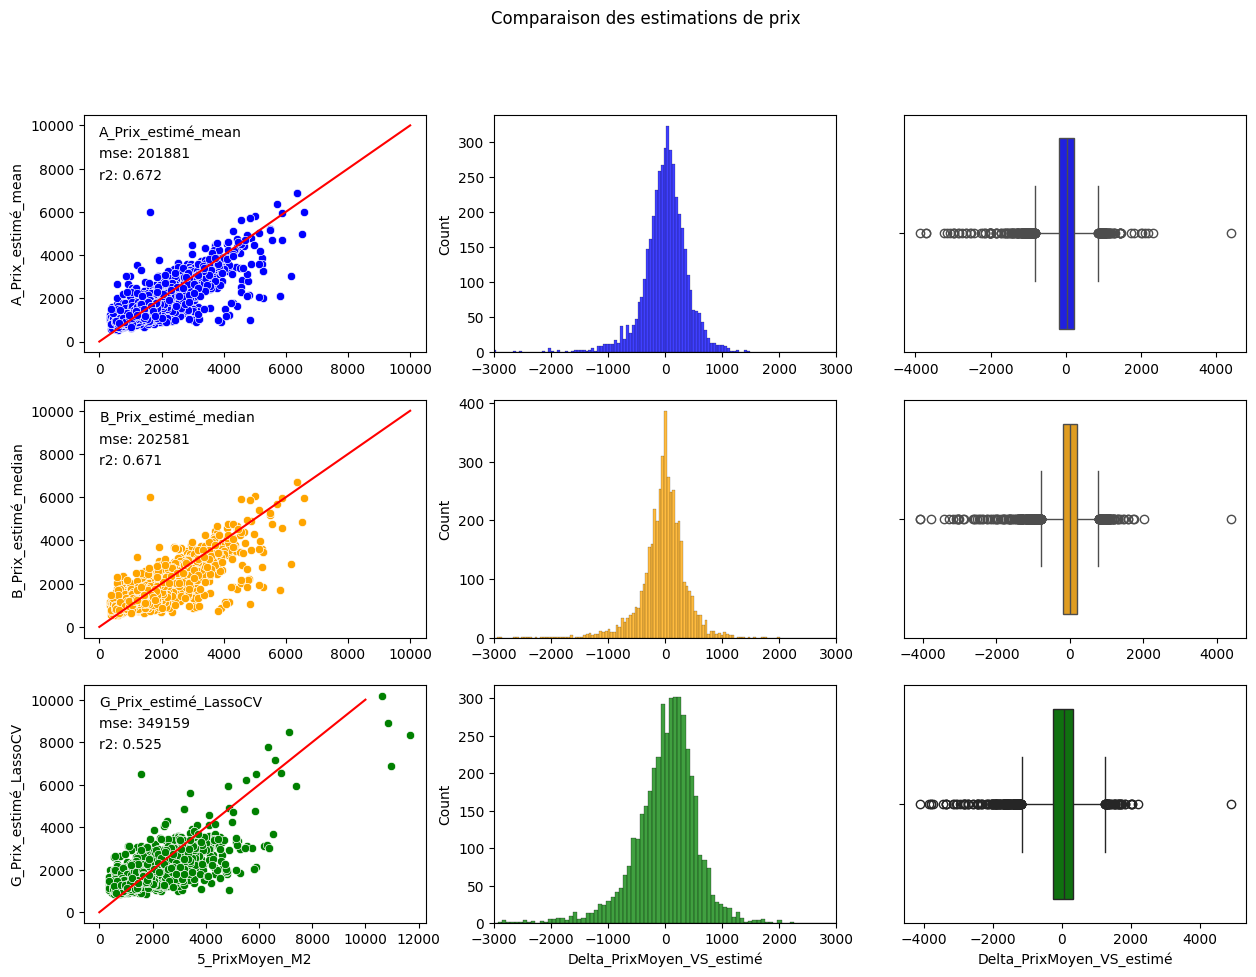

In [315]:
performance_of_simulations('Comparaison des estimations de prix',  ['A_Prix_estimé_mean', 'B_Prix_estimé_median', 'G_Prix_estimé_LassoCV'])